In [1]:
import os, gc, sys, pickle
import h5py, json, math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
import PIL.ImageOps as ImageOps
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import SGD,Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input

c:\users\zaid\anaconda2\envs\tensorflow3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Helper Functiona
def show_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img, interpolation='nearest')
    plt.show()

def step_decay(epoch):
    """ Decay the LR by a factor of 5 for every 10 epochs """
    baseLR = INIT_LR
    decay_factor = 0.2
    power = epoch // 10
    
    # decay LR by 0.1 for every 10 epochs
    alpha = baseLR * (decay_factor ** power)
    return alpha

def finer_step_decay(epoch):
    """ Decay the LR by a factor of 10 for every 10 epochs uniformly """
    baseLR = INIT_LR
    decay_factor = 0.2
    power = epoch // 10
    fine_stepper = epoch % 10
    
    # decay LR by 0.1 for every 10 epochs
    alpha = baseLR * (decay_factor ** (power)) * (1-(1-decay_factor)/10 * fine_stepper)
    return alpha

def visualize_lr(lr_scheduler, epochs):
    x = np.array(range(epochs))
    y = [lr_scheduler(i) for i in x]
    plt.plot(x, y)
    sns.despine()
    plt.show()

def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: float(majority/count) for cls, count in counter.items()}

# Get per class acc and mse
def per_class_scores(conf_mat, label_test):
    MSEs = []
    Ns = []
    for i in range(conf_mat.shape[0]):
        n = np.sum(conf_mat[i, :])
        acc = conf_mat[i,i] / n
        mse = np.sum([conf_mat[i,j] * ((j-i) ** 2) for j in range(conf_mat.shape[1])]) / n
        Ns.append(n)
        MSEs.append(mse)
        print("Label", i, "acc:", acc, " mse:", mse)
    print("Overall acc. is", np.sum([conf_mat[i,i] for i in range(conf_mat.shape[0])]) / len(label_test))
    print("Overall MSE is", np.dot(MSEs, Ns) / np.sum(Ns))

# Load in the train and val data

In [3]:
base_path = "..\\..\\..\\train_data"
file_path = os.path.join(base_path,"file_labels")
img_path = os.path.join(base_path,"bin-images")

In [4]:
df_train = pd.read_csv(file_path+'\\moderate_train.csv', dtype = {'file_name':str, 'lable':np.int8}).drop('sharpness', 1)
df_val = pd.read_csv(file_path+'\\moderate_val.csv', dtype = {'file_name':str, 'lable':np.int8}).drop('sharpness', 1)

print(df_train.shape)
print(df_val.shape)

(289573, 2)
(36197, 2)


Lable: 1


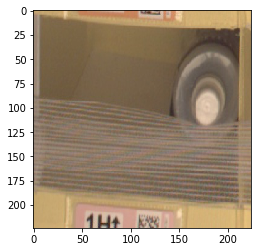

In [5]:
# Load some random images to make sure that the labels are correct
for i in np.random.randint(1,10000, 1):
    path = img_path + '/' + str(df_train.loc[i, "file_name"]) + '.jpg'
    print("Lable:", df_train.loc[i, "label"])
    show_img(path)

# Define the ImageDataGenerator

In [6]:
col_axis = 2
row_axis = 1
img_col_axis = col_axis - 1
img_row_axis = row_axis - 1

In [7]:
def batch_generator(df, batch_size, img_path, num_classes, \
                    horizontal_flip = True, vertical_flip = True, random_rotation = True):
    """This generator use a pandas DataFrame to read images from disk.
    """
    N = df.shape[0]
    while True:
        for start in range(0, N, batch_size):
            x_batch = []
            y_batch = []
            if start + batch_size > N: break
            for ind in range(start, start + batch_size):
#                 name = df.loc[ind, 'file_name']
#                 img = image.load_img(img_path+'/' + str(name) + '.jpg', target_size=(224, 224))
#                 img = image.img_to_array(img)
#                 labelname=df.loc[ind, 'label'] 
#                 x = preprocess_input(img) # Using tf
#                 if horizontal_flip and np.random.random() < 0.5:
#                     x = flip_axis(x, img_col_axis)
#                 if vertical_flip and np.random.random() < 0.5:
#                     x = flip_axis(x, img_row_axis)
#                 x_batch.append(x)
#                 y_batch.append(labelname) 
                
                name = df.loc[ind, 'file_name']
                read_path = img_path+'/' + str(name) + '.jpg'
                x = Image.open(read_path).resize((224, 224))
                # Apply transformation
                if horizontal_flip and np.random.random() < 0.25:
                    x = ImageOps.mirror(x)
                elif vertical_flip and np.random.random() < 0.25:
                    x = ImageOps.flip(x)
                elif random_rotation and np.random.random() < 0.25:
                    x = x.rotate(np.random.choice([90,180,270], 1)[0])
                labelname=df.loc[ind, 'label'] 
                x = np.array(x, dtype = np.float32)
                x = preprocess_input(x) # Using tf
                x_batch.append(x)
                y_batch.append(labelname) 
                    
            x_batch = np.array(x_batch, dtype = np.float32)
            y_batch = to_categorical(y_batch, num_classes = num_classes)
            yield (x_batch, y_batch)

def batch_generator_augment(df, batch_size, img_path, num_classes, \
                    horizontal_flip = True, vertical_flip = True, random_rotation = True):
    """This generator use a pandas DataFrame to read images from disk.
    """
    N = df.shape[0]
    # Change batch size to 1/4 since using 3 types of augmentations:
    batch_size = batch_size // 4
    # Get three randomly sorted array of indecies
    all_lists = [list(np.random.choice(range(N), N, replace = False)) for _ in range(4)]
    
    while True:
        for start in range(0, N, batch_size):
            x_batch = []
            y_batch = []
            if start + batch_size > N: break
            for loc in range(start, start + batch_size):
                for lst_idx in range(len(all_lists)):
                    ind = all_lists[lst_idx].pop()
                    name = df.loc[ind, 'file_name']
                    read_path = img_path+'/' + str(name) + '.jpg'
                    x = Image.open(read_path).resize((224, 224))
                    # Apply transformation
                    if lst_idx == 1 and horizontal_flip:
                        x = ImageOps.mirror(x)
                    elif lst_idx == 2 and vertical_flip:
                        x = ImageOps.flip(x)
                    elif lst_idx == 3 and random_rotation:
                        x = x.rotate(np.random.choice([90,180,270], 1)[0])
                    labelname=df.loc[ind, 'label'] 
                    x = np.array(x, dtype = np.float32)
                    x = preprocess_input(x) # Using tf
                    x_batch.append(x)
                    y_batch.append(labelname) 
            x_batch = np.array(x_batch, dtype = np.float32)
            y_batch = to_categorical(y_batch, num_classes = num_classes)
            yield (x_batch, y_batch)

In [8]:
# create the base pre-trained model
model = ResNet50(weights=None, include_top=True, input_shape = (224, 224, 3), classes = 6)

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [10]:
# output paths
model_output_path = "..\\saved_models\\"
plots_output_path = "..\\visualization\\model_training\\"

NUM_CLASSES = 6
NUM_EPOCHS = 100
BATCH_SIZE = 32
INIT_LR = 5e-3
PATIENCE = 20
model_name = "resnet(caffe)_adam_"+str(BATCH_SIZE) + '_random_augment'
base_filepath = model_output_path + model_name + ".hdf5"

In [11]:
# Define adam optimizer
adam = Adam(lr=INIT_LR) 

# Set up early_stopping_monitor and learning_rate_scheduler
early_stopping_monitor = EarlyStopping(monitor = 'val_loss', patience = PATIENCE)
checkpoint = ModelCheckpoint(base_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks = [early_stopping_monitor, checkpoint] # , learning_rate_schedule
    
# compile the model
model.compile(loss = "categorical_crossentropy",
               optimizer = adam,
               metrics = ['accuracy'])

In [ ]:
np.random.seed(47)
history = model.fit_generator(generator = batch_generator(df_train, 
                                              batch_size=BATCH_SIZE,
                                              img_path=img_path,
                                              num_classes=NUM_CLASSES), 
                    steps_per_epoch = df_train.shape[0] // BATCH_SIZE, #Use BATCH_SIZE for no augmentation
                    validation_data = batch_generator(df_val, 
                                              batch_size=BATCH_SIZE,
                                              img_path=img_path,
                                              num_classes=NUM_CLASSES,
                                              horizontal_flip = False,
                                              vertical_flip = False,
                                              random_rotation = False), 
                    validation_steps = df_val.shape[0] // BATCH_SIZE,
                    epochs = NUM_EPOCHS,
                    callbacks = callbacks,
                    verbose = 1)

Epoch 1/100
  43/9049 [..............................] - ETA: 1:26:32 - loss: 3.0573 - acc: 0.2224

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(plots_output_path + model_name + '_acc', dpi = 300, fmt = 'png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(plots_output_path + model_name + '_loss', dpi = 300, fmt = 'png')
plt.show()

In [ ]:
# Dump history to pickle
file_Name = "..\\model_history_pickle\\" + model_name
f = open(file_Name,'wb') 
pickle.dump(history,f)   
f.close()